In [24]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import gensim
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [3]:
df = pd.read_csv('../rapid_news_cleaned.csv', parse_dates=True, index_col='date').dropna()
df.head()

,body,description,search_string,title
date,,,,
2021-04-05,tweet bumbl nasdaq bmbl recent receiv number p...,bumbl nasdaq bmbl recent receiv number price t...,bumble,week invest analyst rate updat bumbl bmbl
2021-04-03,bmbl stock open wednesday compani day averag b...,wolf research began coverag share bumbl nasdaq...,bumble,bumbl nasdaq bmbl cover wolf research
2021-03-31,style kevin hold groom franco vallelonga era a...,style kevin hold groom franco vallelonga era a...,bumble,thoma penfound archiv
2021-03-31,equiti research analyst wolf research initi co...,equiti research analyst wolf research initi co...,bumble,bumbl nasdaq bmbl research coverag start wolf ...
2021-03-31,serena william perfect martha stewart home dec...,serena william perfect martha stewart home dec...,bumble,serena william gave home tour kitchen martha s...


## Sentiment
#### Add sentiment using Vader/TextBlob

Here we will use the polarity and subjectivity of the sentiment on the description of the news articles.

In [4]:
def get_textblob_subjectivity(string):
    return TextBlob(string).sentiment.subjectivity


def get_textblob_sentiment(string):
    return TextBlob(string).sentiment.polarity

In [5]:
df['subjectivity'] = df.description.apply(get_textblob_subjectivity)
df['sentiment'] = df.description.apply(get_textblob_sentiment)

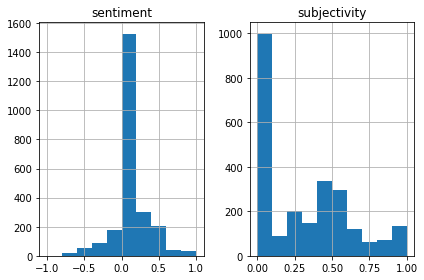

In [6]:
df.hist()
plt.tight_layout()


In [7]:
df_sentiment_scores = df[['sentiment', 'subjectivity']]

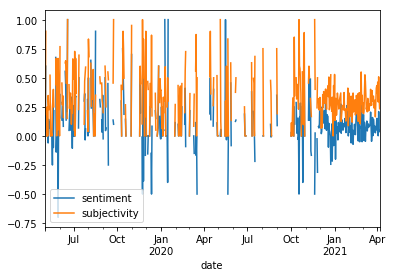

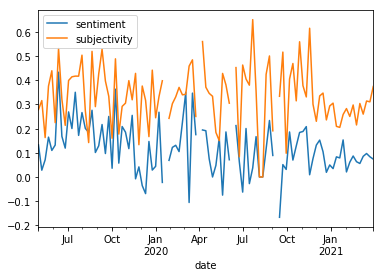

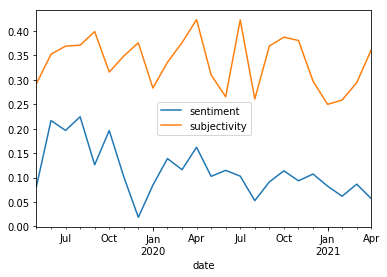

In [8]:
df_sentiment_scores.resample('1D').mean().plot()
df_sentiment_scores.resample('7D').mean().plot()
df_sentiment_scores.resample('1M').mean().plot()


Nothing particularly interesting here; we do see that both subjectivity and sentiment drop down near the more recent months.

#### More opinionated news

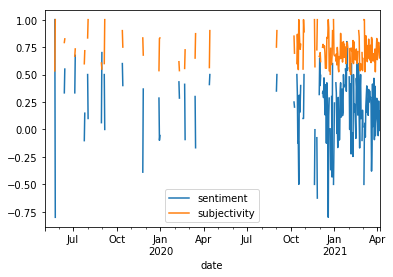

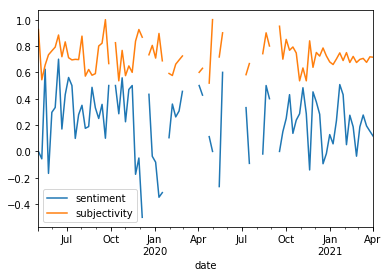

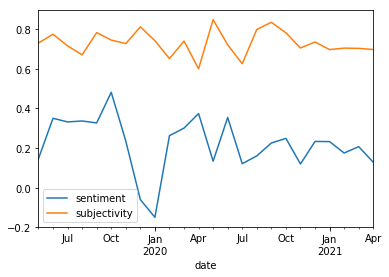

In [9]:
df_sentiment_scores[df_sentiment_scores.subjectivity > 0.5].resample('1D').mean().plot()
df_sentiment_scores[df_sentiment_scores.subjectivity > 0.5].resample('7D').mean().plot()
df_sentiment_scores[df_sentiment_scores.subjectivity > 0.5].resample('1M').mean().plot()

We don't see any trends here; the subjectivity and sentiment are relatively constant.

#### More factual news

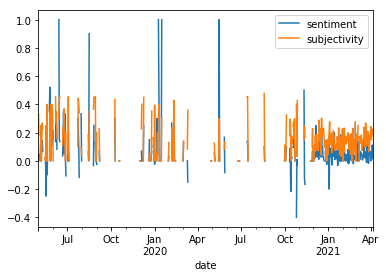

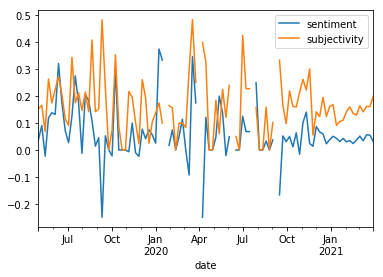

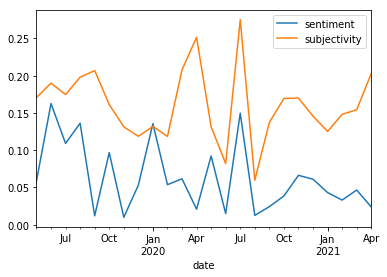

In [10]:
df_sentiment_scores[df_sentiment_scores.subjectivity < 0.5].resample('1D').mean().plot()
df_sentiment_scores[df_sentiment_scores.subjectivity < 0.5].resample('7D').mean().plot()
df_sentiment_scores[df_sentiment_scores.subjectivity < 0.5].resample('1M').mean().plot()

We can see that both the sentiment and the subjectivity drops near the end. This is likely
do to bumble going public, as the articles are likely to be more informational / factual / less
about reviews/thoughts about the app.

This could potentially indicate that with regards to investing, the more important
pieces of info will have less subjectivity and possible more neutral sentiment.

## EDA
High level analysis

### Factual articles

In [11]:
processed_docs = df.description[df.subjectivity < 0.5].apply(lambda x: x.split())
dictionary = gensim.corpora.Dictionary(processed_docs)

id2token = {v: k for k, v in dictionary.token2id.items()}
freq = sorted([(id2token[id], count) for id, count in dictionary.cfs.items()], key=lambda x: -x[1])[:50]
freq[:50]


[('date', 1125),
 ('bumbl', 565),
 ('app', 541),
 ('tinder', 418),
 ('new', 212),
 ('public', 183),
 ('share', 162),
 ('user', 155),
 ('report', 153),
 ('initi', 143),
 ('women', 139),
 ('offer', 137),
 ('onlin', 124),
 ('compani', 123),
 ('peopl', 123),
 ('match', 116),
 ('relationship', 116),
 ('news', 103),
 ('stock', 101),
 ('time', 95),
 ('year', 94),
 ('price', 88),
 ('like', 88),
 ('look', 85),
 ('billion', 79),
 ('bmbl', 75),
 ('wolf', 74),
 ('market', 73),
 ('man', 68),
 ('woman', 65),
 ('herd', 65),
 ('group', 64),
 ('meet', 64),
 ('want', 63),
 ('recent', 62),
 ('whitney', 62),
 ('thursday', 62),
 ('star', 62),
 ('best', 61),
 ('nasdaq', 60),
 ('featur', 60),
 ('check', 60),
 ('site', 59),
 ('said', 57),
 ('million', 56),
 ('start', 55),
 ('singl', 55),
 ('swipe', 54),
 ('world', 53),
 ('potenti', 53)]

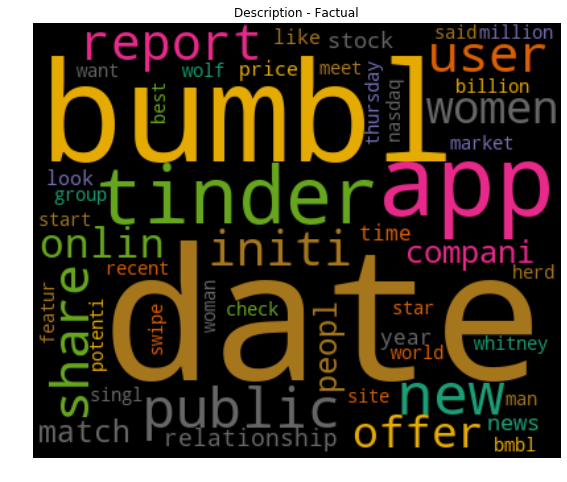

In [12]:
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(dict(freq))
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Description - Factual')
plt.show()


The frequencies seem to be what we would expect: the top words include `bumble`, `app`, `market`, `date`.

In [13]:
def get_freq(data):
    words = []
    data.description.apply(lambda x: words.extend(x.split()))
    freqs_dict = Counter(words)
    freqs = sorted(freqs_dict.items(), key=lambda x: -x[1])
    return freqs[:20]

df[df.subjectivity <0.5]\
    .groupby(df[df.subjectivity < 0.5].index.map(lambda x: x.to_period('Q')))\
    .apply(get_freq)\
    .apply(pd.Series)\
    .reset_index()\
    .transpose()

,0,1,2,3,4,5,6,7,8
date,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2
0,"(date, 55)","(date, 39)","(date, 49)","(date, 33)","(date, 23)","(date, 16)","(date, 138)","(date, 716)","(date, 56)"
1,"(bumbl, 38)","(app, 23)","(bumbl, 39)","(bumbl, 24)","(app, 11)","(app, 14)","(tinder, 90)","(bumbl, 377)","(new, 17)"
2,"(app, 38)","(bumbl, 22)","(app, 38)","(app, 22)","(bumbl, 8)","(bumbl, 9)","(app, 67)","(app, 317)","(tinder, 15)"
3,"(tinder, 25)","(tinder, 15)","(news, 14)","(tinder, 21)","(new, 8)","(public, 7)","(bumbl, 43)","(tinder, 227)","(share, 13)"
4,"(women, 17)","(peopl, 8)","(tinder, 14)","(user, 9)","(tinder, 8)","(offer, 7)","(new, 37)","(public, 163)","(app, 11)"
5,"(user, 13)","(playpen, 8)","(stone, 13)","(swipe, 7)","(coronavirus, 5)","(billion, 6)","(peopl, 24)","(share, 130)","(romanc, 9)"
6,"(like, 10)","(look, 8)","(user, 12)","(stone, 7)","(video, 5)","(initi, 6)","(news, 21)","(initi, 124)","(recent, 8)"
7,"(want, 10)","(new, 8)","(sharon, 11)","(peopl, 6)","(busi, 4)","(new, 5)","(user, 21)","(new, 121)","(report, 8)"
8,"(best, 9)","(want, 7)","(onlin, 9)","(news, 6)","(relationship, 4)","(report, 5)","(man, 19)","(offer, 116)","(year, 7)"


Looking at these frequencies over time, we can see that in 2021 there are more words surrounding the topic of bumble going public.

We will now look at topic modeling through BoW and LDA to see if there are any significant topics that arise from the news articles.

In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [15]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=5, workers=5)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"date" + 0.010*"bumbl" + 0.010*"tinder" + 0.009*"news" + 0.009*"women" + 0.008*"wolf" + 0.008*"herd" + 0.007*"whitney" + 0.007*"app" + 0.006*"compani"
Topic: 1 
Words: 0.030*"date" + 0.014*"tinder" + 0.012*"app" + 0.010*"bumbl" + 0.010*"new" + 0.008*"relationship" + 0.006*"peopl" + 0.006*"like" + 0.005*"report" + 0.005*"look"
Topic: 2 
Words: 0.049*"date" + 0.030*"bumbl" + 0.029*"app" + 0.017*"tinder" + 0.012*"public" + 0.010*"initi" + 0.010*"offer" + 0.009*"user" + 0.008*"share" + 0.008*"report"


In [16]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"app" + 0.004*"date" + 0.004*"bumbl" + 0.003*"tinder" + 0.003*"women" + 0.003*"new" + 0.003*"year" + 0.002*"report" + 0.002*"like" + 0.002*"wolf"
Topic: 1 Word: 0.005*"date" + 0.005*"tinder" + 0.004*"app" + 0.004*"user" + 0.003*"check" + 0.003*"bumbl" + 0.003*"background" + 0.003*"new" + 0.003*"match" + 0.003*"relationship"
Topic: 2 Word: 0.006*"bumbl" + 0.005*"public" + 0.005*"initi" + 0.004*"app" + 0.004*"offer" + 0.004*"date" + 0.004*"share" + 0.004*"billion" + 0.003*"price" + 0.003*"tinder"


We can see that there are two main topics that are surfaced:
- generic articles about a new dating app known as bumble
- articles about bumble going public

### Opinionated articles

In [17]:
processed_docs = df.description[df.subjectivity > 0.5].apply(lambda x: x.split())
dictionary = gensim.corpora.Dictionary(processed_docs)

id2token = {v: k for k, v in dictionary.token2id.items()}
freq = sorted([(id2token[id], count) for id, count in dictionary.cfs.items()], key=lambda x: -x[1])[:50]
freq[:50]


[('date', 450),
 ('app', 202),
 ('tinder', 181),
 ('bumbl', 151),
 ('love', 102),
 ('onlin', 65),
 ('new', 64),
 ('look', 64),
 ('popular', 64),
 ('match', 61),
 ('peopl', 60),
 ('user', 57),
 ('right', 56),
 ('like', 48),
 ('swipe', 43),
 ('year', 38),
 ('compani', 38),
 ('profil', 38),
 ('sexual', 38),
 ('relationship', 35),
 ('site', 33),
 ('meet', 32),
 ('featur', 32),
 ('latest', 31),
 ('news', 31),
 ('women', 29),
 ('partner', 28),
 ('good', 28),
 ('time', 28),
 ('person', 28),
 ('use', 28),
 ('pandem', 27),
 ('come', 26),
 ('report', 26),
 ('free', 26),
 ('share', 25),
 ('life', 25),
 ('help', 25),
 ('base', 24),
 ('woman', 24),
 ('star', 23),
 ('man', 23),
 ('stock', 22),
 ('know', 22),
 ('tri', 22),
 ('singl', 22),
 ('reveal', 21),
 ('men', 21),
 ('want', 21),
 ('fake', 21)]

In [18]:
df[df.subjectivity >0.5]\
    .groupby(df[df.subjectivity > 0.5].index.map(lambda x: x.to_period('Q')))\
    .apply(get_freq)\
    .apply(pd.Series)\
    .reset_index()\
    .transpose()

,0,1,2,3,4,5,6,7,8
date,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2
0,"(date, 22)","(date, 27)","(date, 30)","(date, 16)","(date, 15)","(date, 8)","(date, 70)","(date, 233)","(date, 29)"
1,"(app, 14)","(bumbl, 19)","(bumbl, 24)","(bumbl, 8)","(love, 12)","(bumbl, 8)","(tinder, 47)","(app, 99)","(new, 9)"
2,"(bumbl, 11)","(app, 16)","(app, 19)","(tinder, 7)","(app, 10)","(app, 5)","(app, 29)","(tinder, 91)","(onlin, 8)"
3,"(tinder, 10)","(tinder, 10)","(sharon, 12)","(swipe, 5)","(bumbl, 9)","(latest, 4)","(sexual, 18)","(bumbl, 59)","(peopl, 6)"
4,"(match, 6)","(onlin, 7)","(stone, 12)","(servic, 4)","(look, 7)","(news, 3)","(love, 17)","(love, 59)","(love, 6)"
5,"(popular, 5)","(men, 5)","(fake, 12)","(popular, 4)","(tinder, 6)","(account, 3)","(look, 15)","(match, 39)","(app, 6)"
6,"(peopl, 4)","(sexual, 5)","(user, 10)","(app, 4)","(onlin, 6)","(fan, 3)","(bumbl, 13)","(new, 34)","(free, 4)"
7,"(group, 4)","(locat, 5)","(account, 8)","(seafood, 3)","(help, 5)","(respons, 3)","(popular, 13)","(right, 33)","(featur, 4)"
8,"(use, 3)","(best, 4)","(profil, 7)","(partner, 3)","(like, 4)","(star, 2)","(right, 13)","(look, 32)","(intercours, 4)"


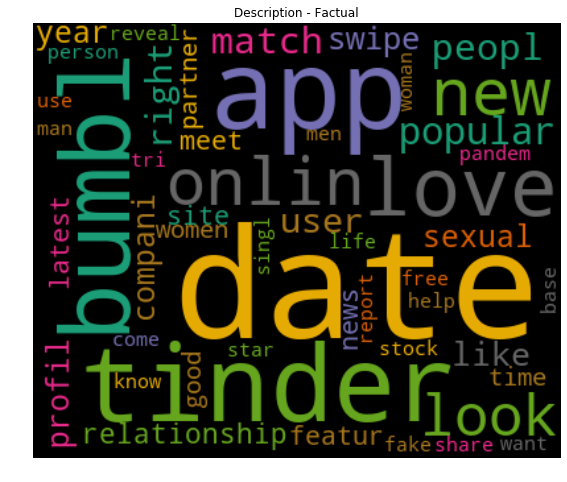

In [20]:
wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(dict(freq))
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Description - Factual')
plt.show()

Looking at the above, we no longer see much information about bumble going public. Rather, most of the words
seem to be closer to the first topic that we elicited earlier. Another interesting fact is that we see more words about
the pandemic/covid in 2020Q1, which we didn't really see in the more factual articles.


In [21]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [22]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=5, workers=5)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"date" + 0.015*"tinder" + 0.012*"bumbl" + 0.011*"app" + 0.009*"new" + 0.009*"love" + 0.008*"match" + 0.006*"onlin" + 0.006*"compani" + 0.006*"person"
Topic: 1 
Words: 0.043*"date" + 0.027*"app" + 0.017*"bumbl" + 0.015*"tinder" + 0.012*"love" + 0.011*"look" + 0.009*"right" + 0.009*"peopl" + 0.007*"swipe" + 0.007*"onlin"
Topic: 2 
Words: 0.044*"date" + 0.017*"tinder" + 0.012*"app" + 0.010*"user" + 0.009*"bumbl" + 0.008*"popular" + 0.005*"site" + 0.005*"like" + 0.004*"profil" + 0.004*"love"


In [23]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.004*"tinder" + 0.004*"app" + 0.003*"bumbl" + 0.003*"love" + 0.003*"date" + 0.003*"right" + 0.003*"new" + 0.003*"swipe" + 0.003*"profil" + 0.003*"featur"
Topic: 1 Word: 0.004*"date" + 0.004*"app" + 0.003*"tinder" + 0.003*"popular" + 0.003*"look" + 0.003*"love" + 0.003*"match" + 0.003*"bumbl" + 0.003*"onlin" + 0.002*"like"
Topic: 2 Word: 0.003*"bumbl" + 0.003*"app" + 0.003*"date" + 0.003*"love" + 0.003*"tinder" + 0.002*"peopl" + 0.002*"user" + 0.002*"woman" + 0.002*"right" + 0.002*"look"


Here, the topics seem to be less about stocks and more about the actual app itself.
There are more topics on swiping, love, relatioship, matchng, etc.